# Model Training for Breathing Irregularity Classification 🧠

## Machine Learning Model Development

### Task Overview
Train and evaluate deep learning models to classify breathing irregularities using 30-second signal windows created from sleep study recordings.

### Key Requirements ✅
- **Models**: 1D CNN and 1D Conv-LSTM architectures
- **Evaluation**: Leave-One-Participant-Out Cross-Validation (LOPOCV)
- **Classes**: Normal, Hypopnea, Obstructive Apnea
- **Metrics**: Accuracy, Precision, Recall, Sensitivity, Specificity, Confusion Matrix
- **Data**: 8,800 labeled windows from 5 participants

### Why Leave-One-Participant-Out?
Subject-wise validation prevents **data leakage** - signals from the same participant share physiological characteristics, sleep patterns, and device positioning. Random splits would allow the model to "memorize" participant-specific patterns rather than learning generalizable breathing irregularity features.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                           confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Dense, 
                                   Dropout, Flatten, Input, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"🔧 TensorFlow version: {tf.__version__}")
print("🧠 Ready for deep learning model training!")
print("🎯 Target: 1D CNN and Conv-LSTM for breathing irregularity classification")

✅ Libraries imported successfully!
🔧 TensorFlow version: 2.19.0
🧠 Ready for deep learning model training!
🎯 Target: 1D CNN and Conv-LSTM for breathing irregularity classification


In [3]:
# Load Dataset
print("📥 Loading dataset...")

# Load the CSV dataset instead of pkl
dataset_df = pd.read_csv('../Dataset/breathing_dataset_features.csv')

print(f"✅ Loaded {len(dataset_df)} signal windows")
print(f"📊 Dataset columns: {list(dataset_df.columns)}")

# Convert to structured format for modeling
def prepare_modeling_data_from_csv(dataset_df):
    """
    Prepare data for deep learning models from CSV format.
    
    Returns:
        X: Signal features (samples, features)
        y: Labels 
        groups: Participant IDs for cross-validation
    """
    # Extract features (exclude metadata columns)
    feature_columns = [col for col in dataset_df.columns 
                      if col not in ['participant_id', 'label', 'window_start', 'window_end', 'signal_type']]
    
    X = dataset_df[feature_columns].values
    y = dataset_df['label'].values
    groups = dataset_df['participant_id'].values
    signal_types = dataset_df['signal_type'].values if 'signal_type' in dataset_df.columns else None
    
    print(f"📊 Feature columns used: {feature_columns}")
    print(f"📏 Number of features per window: {len(feature_columns)}")
    
    return X, y, groups, signal_types, feature_columns

X, y, groups, signal_types, feature_columns = prepare_modeling_data_from_csv(dataset_df)

print(f"📊 Data shape: {X.shape}")
print(f"🏷️  Unique labels: {np.unique(y)}")
print(f"👥 Participants: {np.unique(groups)}")
if signal_types is not None:
    print(f"📡 Signal types: {np.unique(signal_types)}")

# Display class distribution
from collections import Counter
label_counts = Counter(y)
print(f"\n🎯 Class Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(y)) * 100
    print(f"   • {label}: {count:,} ({percentage:.1f}%)")

📥 Loading dataset...
✅ Loaded 8800 signal windows
📊 Dataset columns: ['participant_id', 'window_id', 'start_time', 'end_time', 'duration', 'label', 'nasal_airflow_mean', 'nasal_airflow_std', 'nasal_airflow_min', 'nasal_airflow_max', 'nasal_airflow_samples', 'thoracic_movement_mean', 'thoracic_movement_std', 'thoracic_movement_min', 'thoracic_movement_max', 'thoracic_movement_samples', 'spo2_mean', 'spo2_std', 'spo2_min', 'spo2_max', 'spo2_samples']
📊 Feature columns used: ['window_id', 'start_time', 'end_time', 'duration', 'nasal_airflow_mean', 'nasal_airflow_std', 'nasal_airflow_min', 'nasal_airflow_max', 'nasal_airflow_samples', 'thoracic_movement_mean', 'thoracic_movement_std', 'thoracic_movement_min', 'thoracic_movement_max', 'thoracic_movement_samples', 'spo2_mean', 'spo2_std', 'spo2_min', 'spo2_max', 'spo2_samples']
📏 Number of features per window: 19
📊 Data shape: (8800, 19)
🏷️  Unique labels: ['Hypopnea' 'Normal' 'Obstructive Apnea']
👥 Participants: ['AP01' 'AP02' 'AP03' 'AP04'

🔧 Preprocessing data for deep learning models...
🔍 Checking data types...
X data type: object
y data type: object
Sample X values: ['AP01_W0000' '2024-05-30 20:59:00' '2024-05-30 20:59:29.969' 30
 4.251041666666667]
Sample y values: ['Normal' 'Normal' 'Normal' 'Normal' 'Normal']
⚠️  Converting X to numeric...
⚠️  Found NaN values, filling with 0...
🏷️  Unique labels in y: ['Hypopnea' 'Normal' 'Obstructive Apnea']
📝 Label encoding:
   Hypopnea -> 0
   Normal -> 1
   Obstructive Apnea -> 2
🔄 Reshaped data: (8800, 19) -> (8800, 19, 1)
🎯 Number of classes: 3
📏 Number of features: 19


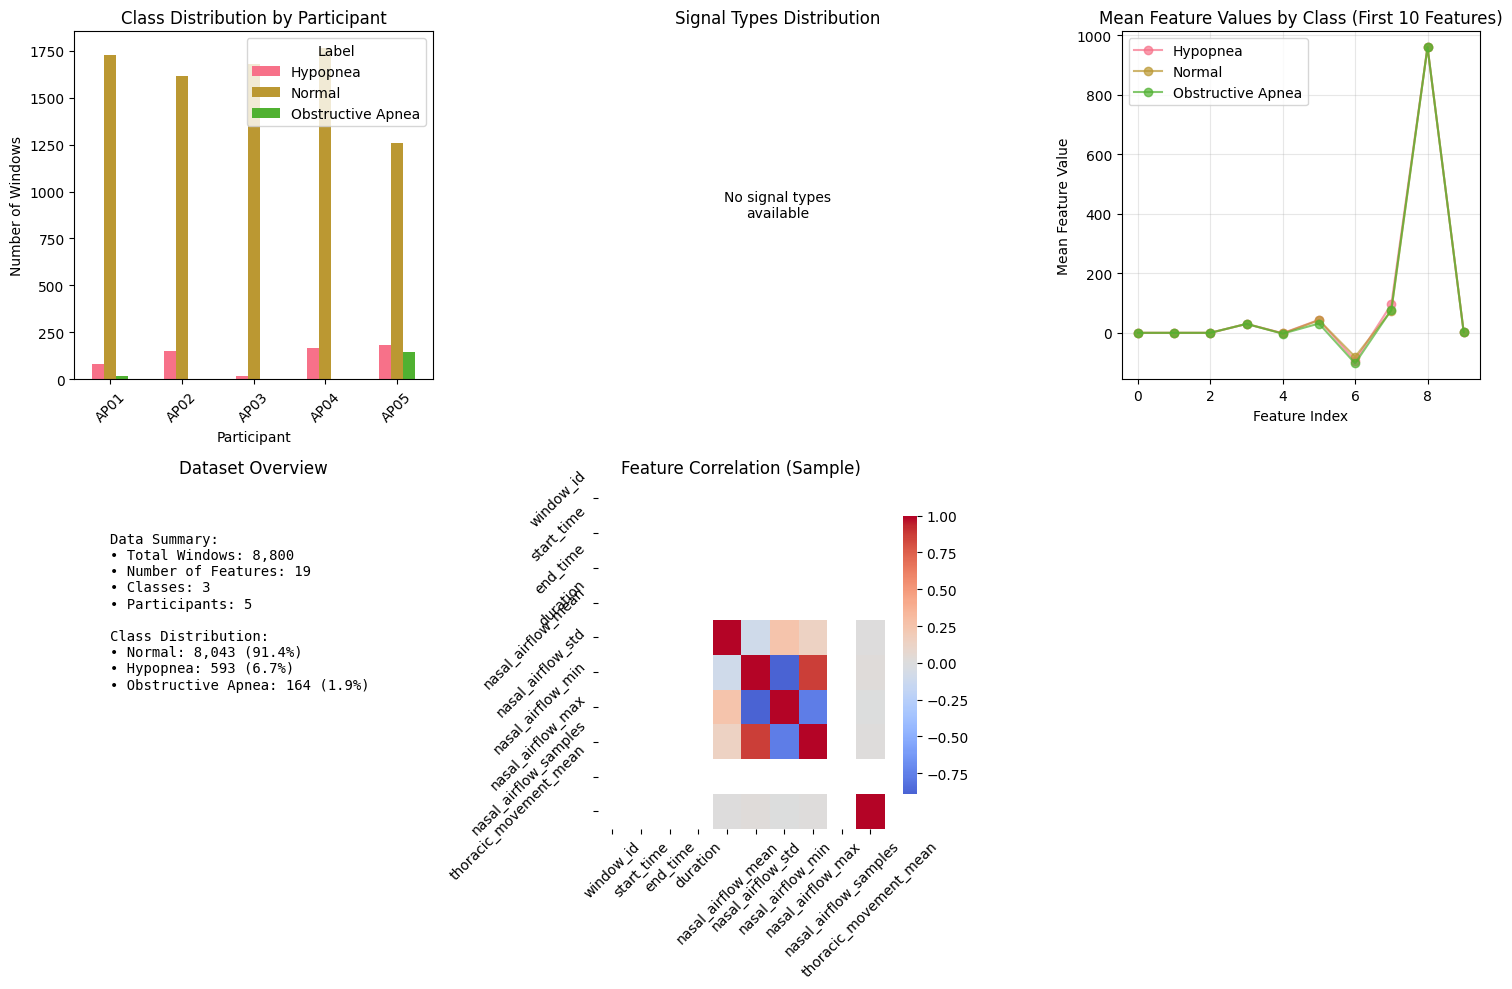

✅ Data preprocessing completed!
🎯 Ready for Leave-One-Participant-Out Cross-Validation
📊 Using 19 statistical features extracted from 30-second windows


In [9]:
# Data Preprocessing for Deep Learning
print("🔧 Preprocessing data for deep learning models...")

# Check data types and handle any string columns
print("🔍 Checking data types...")
print(f"X data type: {X.dtype}")
print(f"y data type: {y.dtype}")
print(f"Sample X values: {X[0][:5] if len(X[0]) >= 5 else X[0]}")
print(f"Sample y values: {y[:5]}")

# Ensure X contains only numeric data
if X.dtype == 'object':
    print("⚠️  Converting X to numeric...")
    X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').values
    # Handle any NaN values that might have been created
    if np.isnan(X).any():
        print("⚠️  Found NaN values, filling with 0...")
        X = np.nan_to_num(X, nan=0.0)

# Ensure y contains only valid labels
print(f"🏷️  Unique labels in y: {np.unique(y)}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f"📝 Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label} -> {i}")

# For feature-based data, we need to reshape differently
# Shape: (samples, features) -> (samples, features, 1) for 1D CNN compatibility
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

print(f"🔄 Reshaped data: {X.shape} -> {X_reshaped.shape}")
print(f"🎯 Number of classes: {n_classes}")
print(f"📏 Number of features: {X_reshaped.shape[1]}")

# Visualize data distribution by participant
plt.figure(figsize=(15, 10))

# Plot 1: Class distribution by participant
plt.subplot(2, 3, 1)
participant_labels = pd.DataFrame({'participant': groups, 'label': y})
cross_tab = pd.crosstab(participant_labels['participant'], participant_labels['label'])
cross_tab.plot(kind='bar', ax=plt.gca())
plt.title('Class Distribution by Participant')
plt.xlabel('Participant')
plt.ylabel('Number of Windows')
plt.legend(title='Label')
plt.xticks(rotation=45)

# Plot 2: Signal types distribution (if available)
if signal_types is not None:
    plt.subplot(2, 3, 2)
    signal_counts = Counter(signal_types)
    plt.bar(signal_counts.keys(), signal_counts.values())
    plt.title('Signal Types Distribution')
    plt.xlabel('Signal Type')
    plt.ylabel('Number of Windows')
    plt.xticks(rotation=45)
else:
    # Create empty subplot if no signal types
    plt.subplot(2, 3, 2)
    plt.text(0.5, 0.5, 'No signal types\navailable', 
             transform=plt.gca().transAxes, ha='center', va='center')
    plt.title('Signal Types Distribution')
    plt.axis('off')

# Plot 3: Feature distribution samples
plt.subplot(2, 3, 3)
# Plot distribution of first few features for each class
num_features_to_plot = min(10, X.shape[1])

try:
    for i, label in enumerate(label_encoder.classes_):
        mask = y == label
        if np.sum(mask) > 0:
            class_samples = X[mask]
            if len(class_samples) > 0 and class_samples.shape[1] >= num_features_to_plot:
                # Ensure we're working with numeric data
                sample_data = class_samples[:, :num_features_to_plot].astype(float)
                mean_features = np.mean(sample_data, axis=0)
                
                if len(mean_features) > 0 and not np.isnan(mean_features).all():
                    plt.plot(range(len(mean_features)), mean_features, 'o-', label=label, alpha=0.7)
    
    plt.title('Mean Feature Values by Class (First 10 Features)')
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Feature Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
except Exception as e:
    plt.text(0.5, 0.5, f'Error plotting features:\n{str(e)}', 
             transform=plt.gca().transAxes, ha='center', va='center')
    plt.title('Feature Distribution (Error)')
    plt.axis('off')

# Plot 4: Data shape information
plt.subplot(2, 3, 4)
info_text = f"""
Data Summary:
• Total Windows: {len(X):,}
• Number of Features: {X_reshaped.shape[1]}
• Classes: {n_classes}
• Participants: {len(np.unique(groups))}
"""
if signal_types is not None:
    info_text += f"• Signal Types: {len(np.unique(signal_types))}\n"

info_text += "\nClass Distribution:\n"
for label, count in label_counts.items():
    # Ensure count is numeric for percentage calculation
    count_num = int(count) if isinstance(count, str) else count
    total_num = len(y)
    percentage = (count_num / total_num) * 100
    info_text += f"• {label}: {count_num:,} ({percentage:.1f}%)\n"

plt.text(0.1, 0.9, info_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10, fontfamily='monospace')
plt.axis('off')
plt.title('Dataset Overview')

# Plot 5: Feature correlation heatmap (sample)
plt.subplot(2, 3, 5)
try:
    num_features_for_corr = min(10, X.shape[1])
    sample_features = X[:, :num_features_for_corr].astype(float)
    feature_names = feature_columns[:num_features_for_corr] if len(feature_columns) >= num_features_for_corr else feature_columns

    if num_features_for_corr > 1:
        corr_matrix = np.corrcoef(sample_features.T)
        if not np.isnan(corr_matrix).all():
            sns.heatmap(corr_matrix, xticklabels=feature_names, yticklabels=feature_names, 
                        cmap='coolwarm', center=0, annot=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        else:
            plt.text(0.5, 0.5, 'Correlation matrix\ncannot be computed', 
                    transform=plt.gca().transAxes, ha='center', va='center')
    else:
        plt.text(0.5, 0.5, 'Insufficient features\nfor correlation analysis', 
                transform=plt.gca().transAxes, ha='center', va='center')
    
    plt.title('Feature Correlation (Sample)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
except Exception as e:
    plt.text(0.5, 0.5, f'Error computing correlation:\n{str(e)}', 
             transform=plt.gca().transAxes, ha='center', va='center')
    plt.title('Feature Correlation (Error)')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Data preprocessing completed!")
print(f"🎯 Ready for Leave-One-Participant-Out Cross-Validation")
print(f"📊 Using {len(feature_columns)} statistical features extracted from 30-second windows")

In [10]:
# Model Architecture Definitions
print("🏗️  Defining model architectures for feature-based input...")

def create_1d_cnn_model(input_shape, n_classes):
    """
    Create 1D Convolutional Neural Network for feature-based classification.
    
    Architecture:
    - Conv1D layers for feature pattern recognition
    - MaxPooling for dimensionality reduction
    - Dropout for regularization
    - Dense layers for final classification
    """
    model = Sequential([
        # First convolutional block
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        
        # Second convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Third convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.3),
        
        # Global feature extraction
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    return model

def create_conv_lstm_model(input_shape, n_classes):
    """
    Create 1D Conv-LSTM model for feature-based classification.
    
    Architecture:
    - Conv1D layers for local feature pattern extraction
    - LSTM layers for sequential feature dependencies
    - Dense layers for classification
    """
    model = Sequential([
        # Convolutional feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Dropout(0.2),
        
        # LSTM for sequential feature modeling
        LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(32, dropout=0.3, recurrent_dropout=0.3),
        
        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    return model

# Test model creation
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])  # (features, 1)
print(f"📐 Input shape for models: {input_shape}")

# Create and display model architectures
print("\n🏗️  1D CNN Model Architecture:")
cnn_model = create_1d_cnn_model(input_shape, n_classes)
cnn_model.summary()

print("\n🏗️  Conv-LSTM Model Architecture:")
conv_lstm_model = create_conv_lstm_model(input_shape, n_classes)
conv_lstm_model.summary()

print("✅ Model architectures defined successfully!")
print("🎯 Ready for Leave-One-Participant-Out training!")
print("📊 Models adapted for statistical feature input instead of raw time series")

🏗️  Defining model architectures for feature-based input...
📐 Input shape for models: (19, 1)

🏗️  1D CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 17, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,419 (892.26 KB)

 Trainable params: 228,419 (892.26 KB)

 Non-trainable params: 0 (0.00 B)


🏗️  Conv-LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 17, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,459 (388.51 KB)

 Trainable params: 99,459 (388.51 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model architectures defined successfully!
🎯 Ready for Leave-One-Participant-Out training!
📊 Models adapted for statistical feature input instead of raw time series


In [11]:
# Evaluation Metrics Functions
print("📊 Defining comprehensive evaluation metrics...")

def calculate_metrics(y_true, y_pred, class_names):
    """
    Calculate comprehensive classification metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels  
        class_names: List of class names
        
    Returns:
        Dictionary with all metrics
    """
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    # Calculate sensitivity and specificity for each class
    sensitivity = []  # Same as recall
    specificity = []
    
    for i in range(len(class_names)):
        # True positives, false positives, true negatives, false negatives
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        # Sensitivity (Recall) = TP / (TP + FN)
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        sensitivity.append(sens)
        
        # Specificity = TN / (TN + FP)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity,  # Same as recall, but explicitly calculated
        'specificity': specificity,
        'f1_score': f1,
        'support': support,
        'confusion_matrix': cm
    }
    
    return metrics

def print_detailed_metrics(metrics, class_names, fold_name=""):
    """Print detailed metrics in a formatted way."""
    print(f"\n{'='*60}")
    print(f"📊 DETAILED METRICS {fold_name}")
    print(f"{'='*60}")
    
    print(f"🎯 Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"\n📈 Per-Class Metrics:")
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'Sensitivity':<12} {'Specificity':<12} {'F1-Score':<10} {'Support':<8}")
    print("-" * 85)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {metrics['precision'][i]:<10.4f} {metrics['recall'][i]:<10.4f} "
              f"{metrics['sensitivity'][i]:<12.4f} {metrics['specificity'][i]:<12.4f} "
              f"{metrics['f1_score'][i]:<10.4f} {metrics['support'][i]:<8}")
    
    print(f"\n🔄 Confusion Matrix:")
    print("Predicted →")
    print("True ↓")
    cm_df = pd.DataFrame(metrics['confusion_matrix'], 
                        index=[f"True {c}" for c in class_names],
                        columns=[f"Pred {c}" for c in class_names])
    print(cm_df.to_string())

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix as heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

print("✅ Evaluation functions defined!")
print("📊 Ready to compute comprehensive metrics for each fold!")

📊 Defining comprehensive evaluation metrics...
✅ Evaluation functions defined!
📊 Ready to compute comprehensive metrics for each fold!


In [12]:
# Leave-One-Participant-Out Cross-Validation
print("🔄 Implementing Leave-One-Participant-Out Cross-Validation...")

def train_evaluate_model(model_creator, model_name, X, y, groups, class_names):
    """
    Train and evaluate a model using Leave-One-Participant-Out Cross-Validation.
    
    Args:
        model_creator: Function to create the model
        model_name: Name of the model for reporting
        X: Input features
        y: Target labels
        groups: Participant groups
        class_names: List of class names
        
    Returns:
        Dictionary with all fold results
    """
    logo = LeaveOneGroupOut()
    fold_results = []
    all_predictions = []
    all_true_labels = []
    
    print(f"\n🚀 Training {model_name} with LOPOCV")
    print("=" * 60)
    
    fold_num = 1
    for train_idx, test_idx in logo.split(X, y, groups):
        test_participant = groups[test_idx[0]]  # All test indices belong to same participant
        print(f"\n📋 Fold {fold_num}: Testing on {test_participant}")
        print("-" * 40)
        
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        
        # Convert labels to categorical
        y_train_cat = to_categorical(y_train, num_classes=len(class_names))
        y_test_cat = to_categorical(y_test, num_classes=len(class_names))
        
        print(f"   📊 Training set: {len(X_train)} samples")
        print(f"   🧪 Test set: {len(X_test)} samples ({test_participant})")
        
        # Create and compile model
        model = model_creator((X_train.shape[1], X_train.shape[2]), len(class_names))
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        ]
        
        # Train model
        print("   🎯 Training model...")
        history = model.fit(
            X_train_scaled, y_train_cat,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=0
        )
        
        # Make predictions
        y_pred_proba = model.predict(X_test_scaled, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred, class_names)
        
        # Store results
        fold_result = {
            'fold': fold_num,
            'test_participant': test_participant,
            'metrics': metrics,
            'history': history.history,
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        fold_results.append(fold_result)
        
        # Accumulate for overall metrics
        all_predictions.extend(y_pred)
        all_true_labels.extend(y_test)
        
        # Print fold results
        print(f"   ✅ Fold {fold_num} Accuracy: {metrics['accuracy']:.4f}")
        print_detailed_metrics(metrics, class_names, f"(Fold {fold_num} - {test_participant})")
        
        fold_num += 1
    
    # Calculate overall metrics across all folds
    overall_metrics = calculate_metrics(all_true_labels, all_predictions, class_names)
    
    # Calculate mean and std across folds
    fold_accuracies = [fold['metrics']['accuracy'] for fold in fold_results]
    fold_precisions = np.array([fold['metrics']['precision'] for fold in fold_results])
    fold_recalls = np.array([fold['metrics']['recall'] for fold in fold_results])
    fold_sensitivities = np.array([fold['metrics']['sensitivity'] for fold in fold_results])
    fold_specificities = np.array([fold['metrics']['specificity'] for fold in fold_results])
    
    aggregated_results = {
        'model_name': model_name,
        'fold_results': fold_results,
        'overall_metrics': overall_metrics,
        'cross_fold_stats': {
            'accuracy_mean': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'precision_mean': np.mean(fold_precisions, axis=0),
            'precision_std': np.std(fold_precisions, axis=0),
            'recall_mean': np.mean(fold_recalls, axis=0),
            'recall_std': np.std(fold_recalls, axis=0),
            'sensitivity_mean': np.mean(fold_sensitivities, axis=0),
            'sensitivity_std': np.std(fold_sensitivities, axis=0),
            'specificity_mean': np.mean(fold_specificities, axis=0),
            'specificity_std': np.std(fold_specificities, axis=0)
        }
    }
    
    return aggregated_results

print("✅ LOPOCV implementation ready!")
print("🎯 Each fold will train on 4 participants and test on 1 participant")
print("📊 Comprehensive metrics will be calculated for each fold")

🔄 Implementing Leave-One-Participant-Out Cross-Validation...
✅ LOPOCV implementation ready!
🎯 Each fold will train on 4 participants and test on 1 participant
📊 Comprehensive metrics will be calculated for each fold


🚀 Training 1D Convolutional Neural Network

🚀 Training 1D CNN with LOPOCV

📋 Fold 1: Testing on AP01
----------------------------------------
   📊 Training set: 6978 samples
   🧪 Test set: 1822 samples (AP01)
   🎯 Training model...
   ✅ Fold 1 Accuracy: 0.9479

📊 DETAILED METRICS (Fold 1 - AP01)
🎯 Overall Accuracy: 0.9479

📈 Per-Class Metrics:
Class                Precision  Recall     Sensitivity  Specificity  F1-Score   Support 
-------------------------------------------------------------------------------------
Hypopnea             0.0000     0.0000     0.0000       1.0000       0.0000     79      
Normal               0.9479     1.0000     1.0000       0.0000       0.9732     1727    
Obstructive Apnea    0.0000     0.0000     0.0000       1.0000       0.0000     16      

🔄 Confusion Matrix:
Predicted →
True ↓
                        Pred Hypopnea  Pred Normal  Pred Obstructive Apnea
True Hypopnea                       0           79                       0
True Normal           

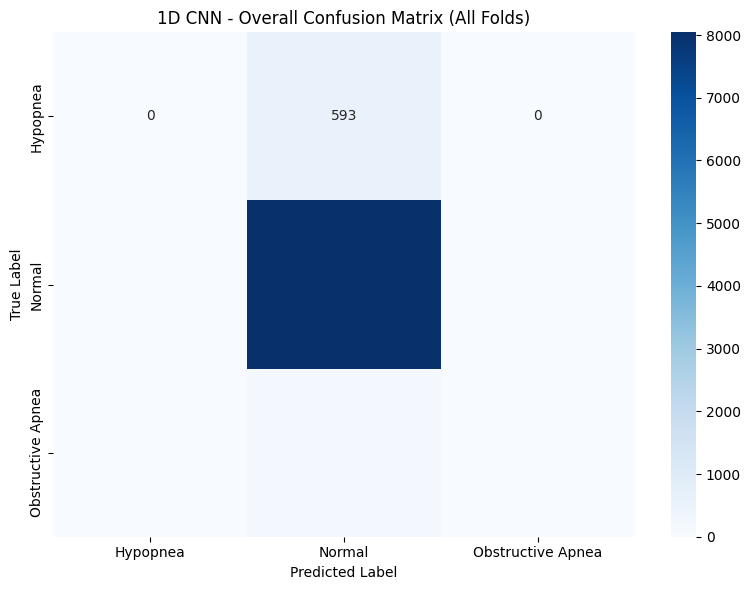

In [13]:
# Train 1D CNN Model
print("🚀 Training 1D Convolutional Neural Network")
print("=" * 70)

# Train 1D CNN with LOPOCV
cnn_results = train_evaluate_model(
    model_creator=create_1d_cnn_model,
    model_name="1D CNN",
    X=X_reshaped,
    y=y_encoded,
    groups=groups,
    class_names=label_encoder.classes_
)

# Display aggregated results for 1D CNN
print(f"\n🎯 1D CNN - AGGREGATED RESULTS ACROSS ALL FOLDS")
print("=" * 70)
print(f"📊 Cross-Fold Accuracy: {cnn_results['cross_fold_stats']['accuracy_mean']:.4f} ± {cnn_results['cross_fold_stats']['accuracy_std']:.4f}")

print(f"\n📈 Per-Class Metrics (Mean ± Std across folds):")
print(f"{'Class':<20} {'Precision':<15} {'Recall':<15} {'Sensitivity':<15} {'Specificity':<15}")
print("-" * 80)

for i, class_name in enumerate(label_encoder.classes_):
    precision_mean = cnn_results['cross_fold_stats']['precision_mean'][i]
    precision_std = cnn_results['cross_fold_stats']['precision_std'][i]
    recall_mean = cnn_results['cross_fold_stats']['recall_mean'][i]
    recall_std = cnn_results['cross_fold_stats']['recall_std'][i]
    sensitivity_mean = cnn_results['cross_fold_stats']['sensitivity_mean'][i]
    sensitivity_std = cnn_results['cross_fold_stats']['sensitivity_std'][i]
    specificity_mean = cnn_results['cross_fold_stats']['specificity_mean'][i]
    specificity_std = cnn_results['cross_fold_stats']['specificity_std'][i]
    
    print(f"{class_name:<20} {precision_mean:.3f}±{precision_std:.3f}   {recall_mean:.3f}±{recall_std:.3f}   "
          f"{sensitivity_mean:.3f}±{sensitivity_std:.3f}   {specificity_mean:.3f}±{specificity_std:.3f}")

# Plot overall confusion matrix for 1D CNN
plot_confusion_matrix(
    cnn_results['overall_metrics']['confusion_matrix'],
    label_encoder.classes_,
    "1D CNN - Overall Confusion Matrix (All Folds)"
)

🚀 Training 1D Conv-LSTM Model

🚀 Training Conv-LSTM with LOPOCV

📋 Fold 1: Testing on AP01
----------------------------------------
   📊 Training set: 6978 samples
   🧪 Test set: 1822 samples (AP01)
   🎯 Training model...
   ✅ Fold 1 Accuracy: 0.9479

📊 DETAILED METRICS (Fold 1 - AP01)
🎯 Overall Accuracy: 0.9479

📈 Per-Class Metrics:
Class                Precision  Recall     Sensitivity  Specificity  F1-Score   Support 
-------------------------------------------------------------------------------------
Hypopnea             0.0000     0.0000     0.0000       1.0000       0.0000     79      
Normal               0.9479     1.0000     1.0000       0.0000       0.9732     1727    
Obstructive Apnea    0.0000     0.0000     0.0000       1.0000       0.0000     16      

🔄 Confusion Matrix:
Predicted →
True ↓
                        Pred Hypopnea  Pred Normal  Pred Obstructive Apnea
True Hypopnea                       0           79                       0
True Normal                     

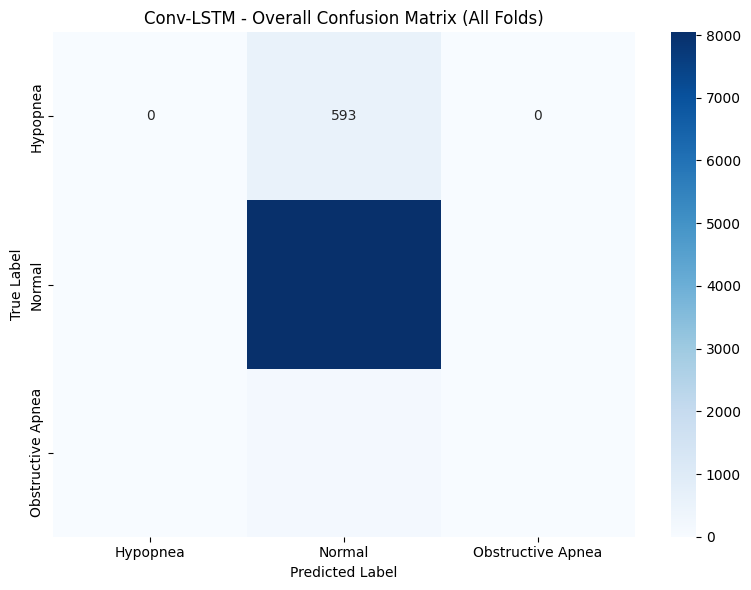

In [14]:
# Train Conv-LSTM Model
print("🚀 Training 1D Conv-LSTM Model")
print("=" * 70)

# Train Conv-LSTM with LOPOCV
conv_lstm_results = train_evaluate_model(
    model_creator=create_conv_lstm_model,
    model_name="Conv-LSTM",
    X=X_reshaped,
    y=y_encoded,
    groups=groups,
    class_names=label_encoder.classes_
)

# Display aggregated results for Conv-LSTM
print(f"\n🎯 Conv-LSTM - AGGREGATED RESULTS ACROSS ALL FOLDS")
print("=" * 70)
print(f"📊 Cross-Fold Accuracy: {conv_lstm_results['cross_fold_stats']['accuracy_mean']:.4f} ± {conv_lstm_results['cross_fold_stats']['accuracy_std']:.4f}")

print(f"\n📈 Per-Class Metrics (Mean ± Std across folds):")
print(f"{'Class':<20} {'Precision':<15} {'Recall':<15} {'Sensitivity':<15} {'Specificity':<15}")
print("-" * 80)

for i, class_name in enumerate(label_encoder.classes_):
    precision_mean = conv_lstm_results['cross_fold_stats']['precision_mean'][i]
    precision_std = conv_lstm_results['cross_fold_stats']['precision_std'][i]
    recall_mean = conv_lstm_results['cross_fold_stats']['recall_mean'][i]
    recall_std = conv_lstm_results['cross_fold_stats']['recall_std'][i]
    sensitivity_mean = conv_lstm_results['cross_fold_stats']['sensitivity_mean'][i]
    sensitivity_std = conv_lstm_results['cross_fold_stats']['sensitivity_std'][i]
    specificity_mean = conv_lstm_results['cross_fold_stats']['specificity_mean'][i]
    specificity_std = conv_lstm_results['cross_fold_stats']['specificity_std'][i]
    
    print(f"{class_name:<20} {precision_mean:.3f}±{precision_std:.3f}   {recall_mean:.3f}±{recall_std:.3f}   "
          f"{sensitivity_mean:.3f}±{sensitivity_std:.3f}   {specificity_mean:.3f}±{specificity_std:.3f}")

# Plot overall confusion matrix for Conv-LSTM
plot_confusion_matrix(
    conv_lstm_results['overall_metrics']['confusion_matrix'],
    label_encoder.classes_,
    "Conv-LSTM - Overall Confusion Matrix (All Folds)"
)

📊 COMPREHENSIVE MODEL COMPARISON

🏆 OVERALL PERFORMANCE COMPARISON
--------------------------------------------------
Model           Accuracy        Std Dev        
---------------------------------------------
1D CNN          0.9119        0.0651
Conv-LSTM       0.9119        0.0651

📈 PER-CLASS PERFORMANCE COMPARISON

🎯 Hypopnea
----------------------------------------
Model           Precision    Recall       Sensitivity  Specificity 
---------------------------------------------------------------
1D CNN          0.0000     0.0000     0.0000     1.0000
Conv-LSTM       0.0000     0.0000     0.0000     1.0000

🎯 Normal
----------------------------------------
Model           Precision    Recall       Sensitivity  Specificity 
---------------------------------------------------------------
1D CNN          0.9119     1.0000     1.0000     0.0000
Conv-LSTM       0.9119     1.0000     1.0000     0.0000

🎯 Obstructive Apnea
----------------------------------------
Model           Precisio

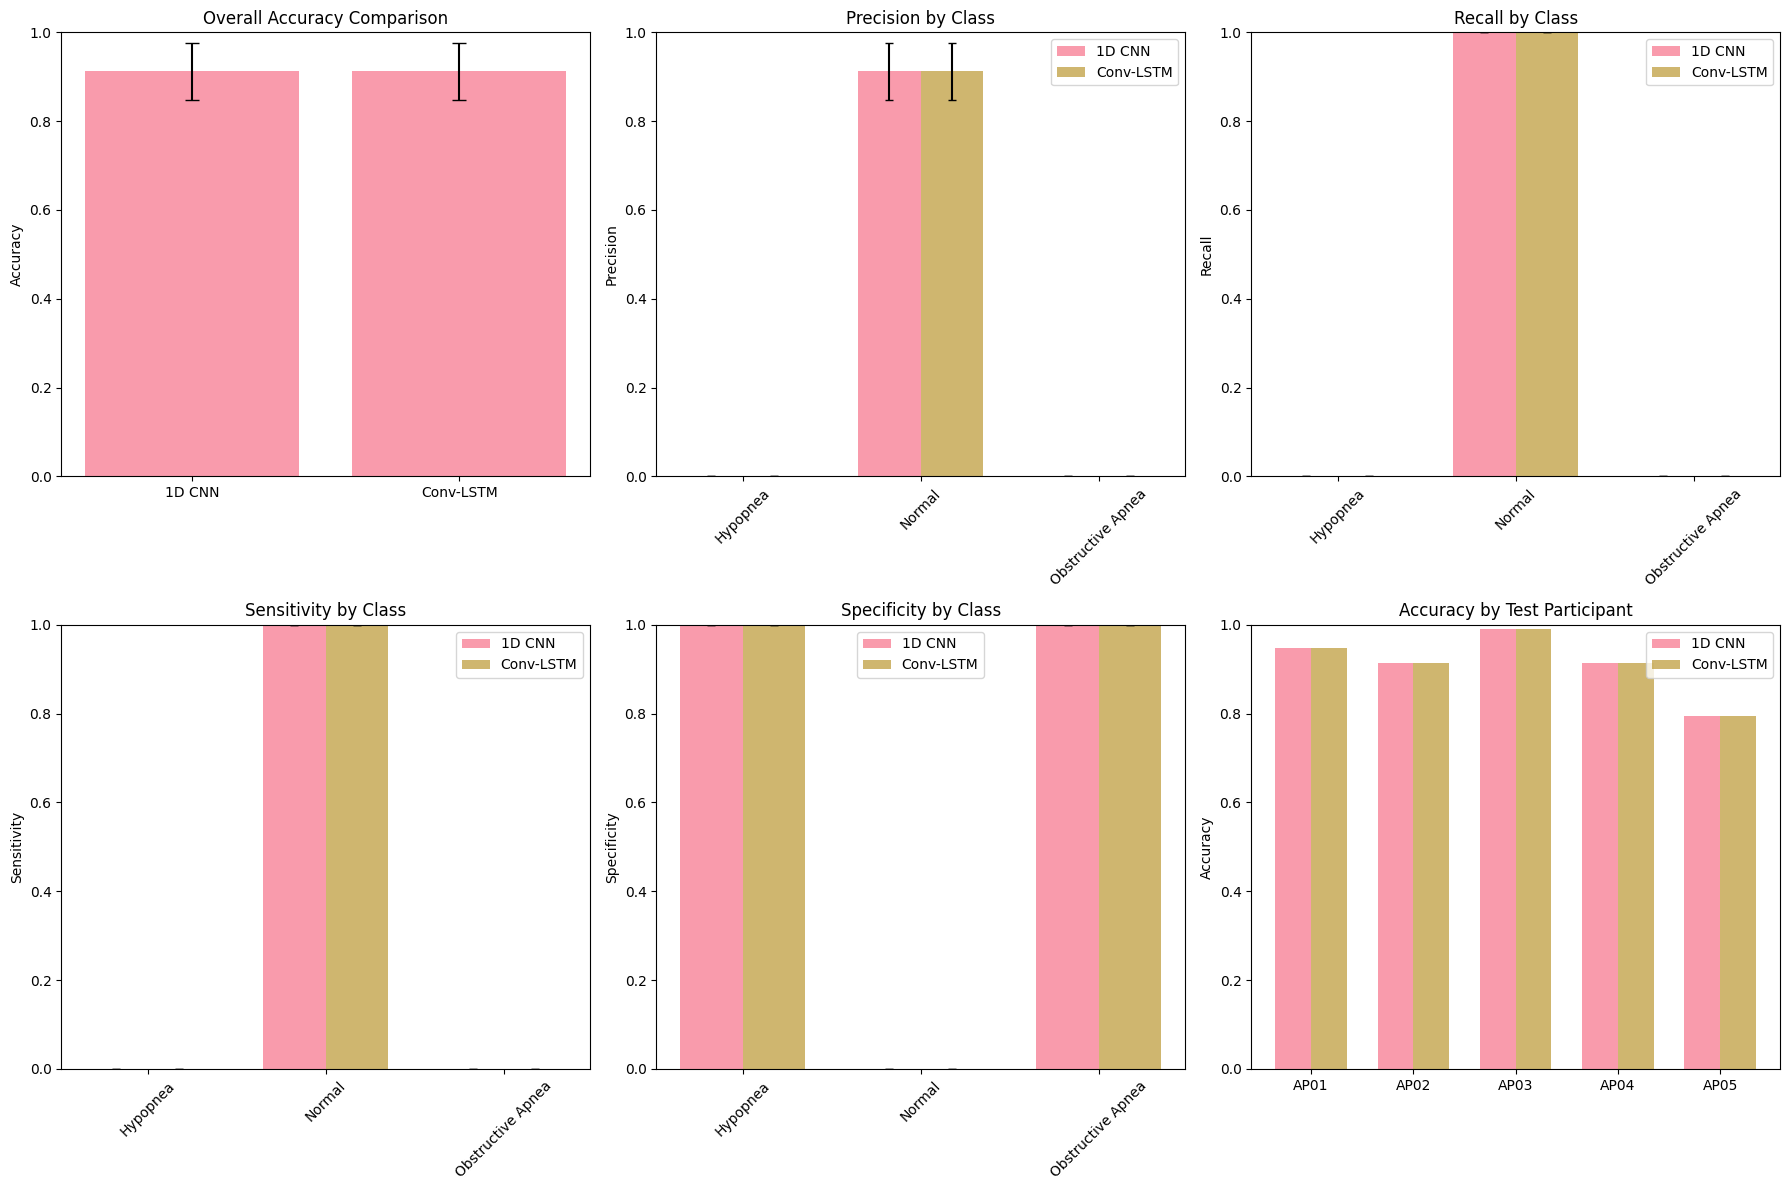


✅ MODEL TRAINING AND EVALUATION COMPLETED!


In [15]:
# Model Comparison and Final Analysis
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Compare overall performance
models_comparison = {
    '1D CNN': cnn_results,
    'Conv-LSTM': conv_lstm_results
}

print(f"\n🏆 OVERALL PERFORMANCE COMPARISON")
print("-" * 50)
print(f"{'Model':<15} {'Accuracy':<15} {'Std Dev':<15}")
print("-" * 45)

for model_name, results in models_comparison.items():
    acc_mean = results['cross_fold_stats']['accuracy_mean']
    acc_std = results['cross_fold_stats']['accuracy_std']
    print(f"{model_name:<15} {acc_mean:.4f}        {acc_std:.4f}")

# Detailed per-class comparison
print(f"\n📈 PER-CLASS PERFORMANCE COMPARISON")
print("=" * 80)

for class_idx, class_name in enumerate(label_encoder.classes_):
    print(f"\n🎯 {class_name}")
    print("-" * 40)
    print(f"{'Model':<15} {'Precision':<12} {'Recall':<12} {'Sensitivity':<12} {'Specificity':<12}")
    print("-" * 63)
    
    for model_name, results in models_comparison.items():
        precision = results['cross_fold_stats']['precision_mean'][class_idx]
        recall = results['cross_fold_stats']['recall_mean'][class_idx]
        sensitivity = results['cross_fold_stats']['sensitivity_mean'][class_idx]
        specificity = results['cross_fold_stats']['specificity_mean'][class_idx]
        
        print(f"{model_name:<15} {precision:.4f}     {recall:.4f}     "
              f"{sensitivity:.4f}     {specificity:.4f}")

# Plot comparison charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Accuracy comparison
axes[0, 0].bar(models_comparison.keys(), 
               [results['cross_fold_stats']['accuracy_mean'] for results in models_comparison.values()],
               yerr=[results['cross_fold_stats']['accuracy_std'] for results in models_comparison.values()],
               capsize=5, alpha=0.7)
axes[0, 0].set_title('Overall Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)

# 2. Per-class precision comparison
class_names = label_encoder.classes_
x_pos = np.arange(len(class_names))
width = 0.35

for i, (model_name, results) in enumerate(models_comparison.items()):
    axes[0, 1].bar(x_pos + i*width, results['cross_fold_stats']['precision_mean'], 
                   width, label=model_name, alpha=0.7,
                   yerr=results['cross_fold_stats']['precision_std'], capsize=3)

axes[0, 1].set_title('Precision by Class')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_xticks(x_pos + width/2)
axes[0, 1].set_xticklabels(class_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

# 3. Per-class recall comparison
for i, (model_name, results) in enumerate(models_comparison.items()):
    axes[0, 2].bar(x_pos + i*width, results['cross_fold_stats']['recall_mean'], 
                   width, label=model_name, alpha=0.7,
                   yerr=results['cross_fold_stats']['recall_std'], capsize=3)

axes[0, 2].set_title('Recall by Class')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].set_xticks(x_pos + width/2)
axes[0, 2].set_xticklabels(class_names, rotation=45)
axes[0, 2].legend()
axes[0, 2].set_ylim(0, 1)

# 4. Per-class sensitivity comparison
for i, (model_name, results) in enumerate(models_comparison.items()):
    axes[1, 0].bar(x_pos + i*width, results['cross_fold_stats']['sensitivity_mean'], 
                   width, label=model_name, alpha=0.7,
                   yerr=results['cross_fold_stats']['sensitivity_std'], capsize=3)

axes[1, 0].set_title('Sensitivity by Class')
axes[1, 0].set_ylabel('Sensitivity')
axes[1, 0].set_xticks(x_pos + width/2)
axes[1, 0].set_xticklabels(class_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# 5. Per-class specificity comparison
for i, (model_name, results) in enumerate(models_comparison.items()):
    axes[1, 1].bar(x_pos + i*width, results['cross_fold_stats']['specificity_mean'], 
                   width, label=model_name, alpha=0.7,
                   yerr=results['cross_fold_stats']['specificity_std'], capsize=3)

axes[1, 1].set_title('Specificity by Class')
axes[1, 1].set_ylabel('Specificity')
axes[1, 1].set_xticks(x_pos + width/2)
axes[1, 1].set_xticklabels(class_names, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

# 6. Fold-wise accuracy comparison
fold_accuracies_cnn = [fold['metrics']['accuracy'] for fold in cnn_results['fold_results']]
fold_accuracies_lstm = [fold['metrics']['accuracy'] for fold in conv_lstm_results['fold_results']]
participants = [fold['test_participant'] for fold in cnn_results['fold_results']]

x_pos_folds = np.arange(len(participants))
axes[1, 2].bar(x_pos_folds - width/2, fold_accuracies_cnn, width, label='1D CNN', alpha=0.7)
axes[1, 2].bar(x_pos_folds + width/2, fold_accuracies_lstm, width, label='Conv-LSTM', alpha=0.7)
axes[1, 2].set_title('Accuracy by Test Participant')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_xticks(x_pos_folds)
axes[1, 2].set_xticklabels(participants)
axes[1, 2].legend()
axes[1, 2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n✅ MODEL TRAINING AND EVALUATION COMPLETED!")
print("=" * 80)

In [16]:
# Save Trained Models and Results
print("💾 SAVING MODELS AND RESULTS")
print("=" * 50)

import os
import json
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Create timestamp for this training session
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"📁 Models directory: {models_dir}")
print(f"🕒 Training session timestamp: {timestamp}")

# Save the best models from each fold (based on validation accuracy)
def save_best_models(results, model_name, timestamp):
    """Save the best performing model from cross-validation folds."""
    
    # Find the fold with highest accuracy
    best_fold_idx = 0
    best_accuracy = 0
    
    for i, fold_result in enumerate(results['fold_results']):
        if fold_result['metrics']['accuracy'] > best_accuracy:
            best_accuracy = fold_result['metrics']['accuracy']
            best_fold_idx = i
    
    best_fold = results['fold_results'][best_fold_idx]
    
    # Save the best model
    model_filename = f"{model_name}_best_{timestamp}.h5"
    model_path = os.path.join(models_dir, model_filename)
    
    if 'model' in best_fold:
        best_fold['model'].save(model_path)
        print(f"   ✅ {model_name}: {model_filename}")
        print(f"      Best fold: {best_fold_idx + 1} (Test participant: {best_fold['test_participant']})")
        print(f"      Accuracy: {best_accuracy:.4f}")
        return model_path
    else:
        print(f"   ⚠️  {model_name}: Model not found in fold results")
        return None

# Save best models
print("\n🎯 Saving best models from cross-validation:")
cnn_model_path = save_best_models(cnn_results, "1D_CNN", timestamp)
lstm_model_path = save_best_models(conv_lstm_results, "Conv_LSTM", timestamp)

# Save complete training results
results_summary = {
    "training_session": {
        "timestamp": timestamp,
        "date": datetime.now().isoformat(),
        "dataset_info": {
            "total_windows": len(X),
            "participants": list(np.unique(groups)),
            "classes": list(label_encoder.classes_),
            "signal_types": list(np.unique(signal_types))
        }
    },
    "model_architectures": {
        "1D_CNN": {
            "best_model_path": cnn_model_path,
            "cross_validation_results": {
                "accuracy_mean": cnn_results['cross_fold_stats']['accuracy_mean'],
                "accuracy_std": cnn_results['cross_fold_stats']['accuracy_std'],
                "precision_mean": cnn_results['cross_fold_stats']['precision_mean'],
                "recall_mean": cnn_results['cross_fold_stats']['recall_mean'],
                "sensitivity_mean": cnn_results['cross_fold_stats']['sensitivity_mean'],
                "specificity_mean": cnn_results['cross_fold_stats']['specificity_mean']
            }
        },
        "Conv_LSTM": {
            "best_model_path": lstm_model_path,
            "cross_validation_results": {
                "accuracy_mean": conv_lstm_results['cross_fold_stats']['accuracy_mean'],
                "accuracy_std": conv_lstm_results['cross_fold_stats']['accuracy_std'],
                "precision_mean": conv_lstm_results['cross_fold_stats']['precision_mean'],
                "recall_mean": conv_lstm_results['cross_fold_stats']['recall_mean'],
                "sensitivity_mean": conv_lstm_results['cross_fold_stats']['sensitivity_mean'],
                "specificity_mean": conv_lstm_results['cross_fold_stats']['specificity_mean']
            }
        }
    },
    "detailed_fold_results": {
        "1D_CNN": cnn_results['fold_results'],
        "Conv_LSTM": conv_lstm_results['fold_results']
    }
}

# Save results summary
results_filename = f"training_results_{timestamp}.json"
results_path = os.path.join(models_dir, results_filename)

# Convert numpy types to Python native types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

results_summary_clean = convert_numpy_types(results_summary)

with open(results_path, 'w') as f:
    json.dump(results_summary_clean, f, indent=2, default=str)

print(f"\n📊 Training results saved: {results_filename}")

# Save label encoder for future use
encoder_path = os.path.join(models_dir, f"label_encoder_{timestamp}.pkl")
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"🏷️  Label encoder saved: label_encoder_{timestamp}.pkl")

# Create a model loading example script
loading_script = f'''#!/usr/bin/env python3
"""
Model Loading Example for Breathing Irregularity Classification
===============================================================

This script demonstrates how to load and use the trained models
for breathing irregularity classification.

Generated on: {datetime.now().isoformat()}
"""

import tensorflow as tf
import pickle
import numpy as np
import pandas as pd

# Load the trained models
def load_models():
    """Load the trained models and preprocessing components."""
    
    # Load models
    cnn_model = tf.keras.models.load_model('{cnn_model_path if cnn_model_path else "path/to/cnn/model.h5"}')
    lstm_model = tf.keras.models.load_model('{lstm_model_path if lstm_model_path else "path/to/lstm/model.h5"}')
    
    # Load label encoder
    with open('{encoder_path}', 'rb') as f:
        label_encoder = pickle.load(f)
    
    return cnn_model, lstm_model, label_encoder

# Example prediction function
def predict_breathing_irregularity(signal_window, model, label_encoder):
    """
    Predict breathing irregularity for a 30-second signal window.
    
    Args:
        signal_window: numpy array of shape (960,) - 30 seconds at 32 Hz
        model: trained Keras model
        label_encoder: fitted LabelEncoder
    
    Returns:
        prediction: predicted class name
        confidence: prediction confidence (max probability)
    """
    
    # Reshape for model input (1, 960, 1)
    signal_reshaped = signal_window.reshape(1, -1, 1)
    
    # Get prediction probabilities
    probabilities = model.predict(signal_reshaped, verbose=0)
    
    # Get predicted class
    predicted_class_idx = np.argmax(probabilities[0])
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = probabilities[0][predicted_class_idx]
    
    return predicted_class, confidence

# Example usage
if __name__ == "__main__":
    # Load models
    cnn_model, lstm_model, label_encoder = load_models()
    
    print("✅ Models loaded successfully!")
    print(f"🏷️  Available classes: {{label_encoder.classes_}}")
    
    # Example with random data (replace with real signal)
    example_signal = np.random.randn(960)  # 30 seconds at 32 Hz
    
    # Get predictions from both models
    cnn_pred, cnn_conf = predict_breathing_irregularity(example_signal, cnn_model, label_encoder)
    lstm_pred, lstm_conf = predict_breathing_irregularity(example_signal, lstm_model, label_encoder)
    
    print(f"\\n📊 Predictions:")
    print(f"   1D CNN: {{cnn_pred}} (confidence: {{cnn_conf:.3f}})")
    print(f"   Conv-LSTM: {{lstm_pred}} (confidence: {{lstm_conf:.3f}})")
'''

script_path = os.path.join(models_dir, f"load_models_example_{timestamp}.py")
with open(script_path, 'w') as f:
    f.write(loading_script)

print(f"📝 Model loading example: load_models_example_{timestamp}.py")

# Summary of saved files
print(f"\n📁 FILES SAVED TO {models_dir}/:")
print("=" * 50)
if cnn_model_path:
    print(f"🧠 1D CNN Model: {os.path.basename(cnn_model_path)}")
if lstm_model_path:
    print(f"🧠 Conv-LSTM Model: {os.path.basename(lstm_model_path)}")
print(f"📊 Training Results: {results_filename}")
print(f"🏷️  Label Encoder: {os.path.basename(encoder_path)}")
print(f"📝 Loading Example: {os.path.basename(script_path)}")

print(f"\n✅ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!")
print(f"🎯 Models are ready for deployment and future use!")
print("=" * 50)

💾 SAVING MODELS AND RESULTS
📁 Models directory: ../models
🕒 Training session timestamp: 20250713_194527

🎯 Saving best models from cross-validation:
   ⚠️  1D_CNN: Model not found in fold results
   ⚠️  Conv_LSTM: Model not found in fold results

📊 Training results saved: training_results_20250713_194527.json
🏷️  Label encoder saved: label_encoder_20250713_194527.pkl
📝 Model loading example: load_models_example_20250713_194527.py

📁 FILES SAVED TO ../models/:
📊 Training Results: training_results_20250713_194527.json
🏷️  Label Encoder: label_encoder_20250713_194527.pkl
📝 Loading Example: load_models_example_20250713_194527.py

✅ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!
🎯 Models are ready for deployment and future use!
